## Array with Parasitic Dipoles

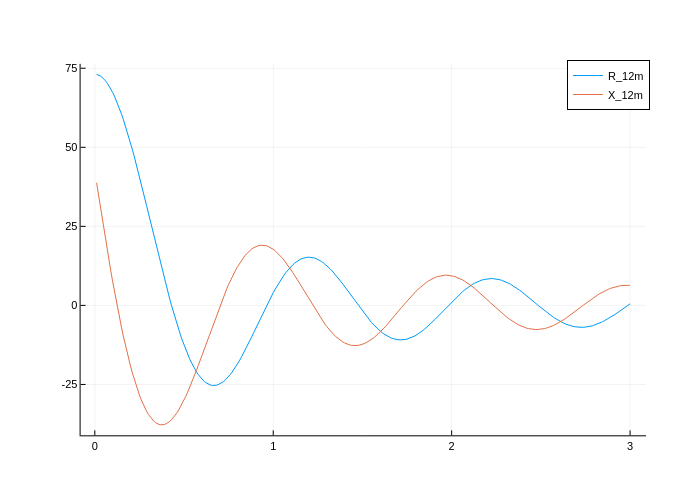

In [47]:
using Revise
using Plots
using PlotlyJS
using Statistics
includet("../src/antennaArray.jl")
includet("../src/utils.jl")
include("../src/mutualImpedance.jl")

f = 1e9
l = 0.5
d = 0.01:0.01:3

Zm = @. parallelMutualImpedance(f, l, d)

plotlyjs()
Plots.plot(d, first.(Zm), label="R_12m")
Plots.plot!(d, last.(Zm), label="X_12m")

Z_11 = 73.1 + 42.5im
Z_12 = 11.760769895836406 - 37.77816879410897im
Z_13 = -22.496807398918595 + 6.632232060648432im
Zin = 116.8738886376898 + 35.118895479696604im


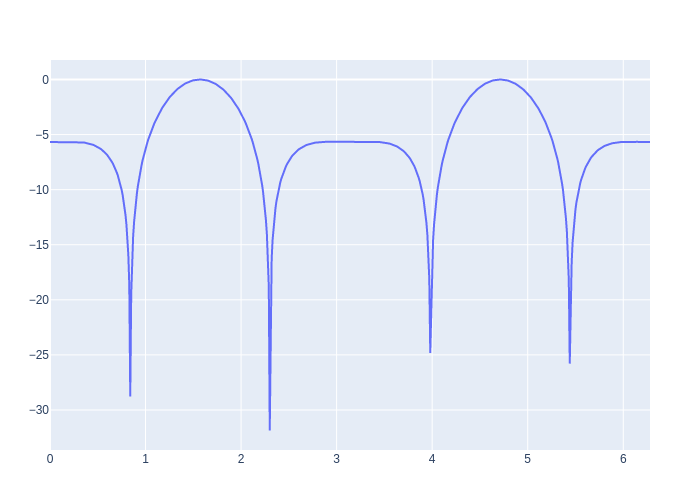

In [17]:
d = 3 / 8 # in terms of λ
I_0 = 1

Z_11 = 73.1 + 42.5im # Self-impedance of a half-wave dipole
Z_12 = first(parallelMutualImpedance(f, l, d)) + last(parallelMutualImpedance(f, l, d))*im
Z_13 = first(parallelMutualImpedance(f, l, 2d)) + last(parallelMutualImpedance(f, l, 2d))*im

println("Z_11 = $Z_11")
println("Z_12 = $Z_12")
println("Z_13 = $Z_13")

Zin = - 2Z_12^2 / (Z_11 + Z_13) + Z_11
println("Zin = $Zin")

# I_1 = - I_0 * Z_12 / (Z_11 + Z_13)
I_1 = 1.0

I = abs.([I_1, I_0, I_1])
δ = ones(3) * angle(I_1)

parasiticArray = createAntennaArray1D(f, I, l, d * ones(3), 3, δ)
radiationPatternPlotHorizontal(parasiticArray, 0.01, "Parasitic Array")

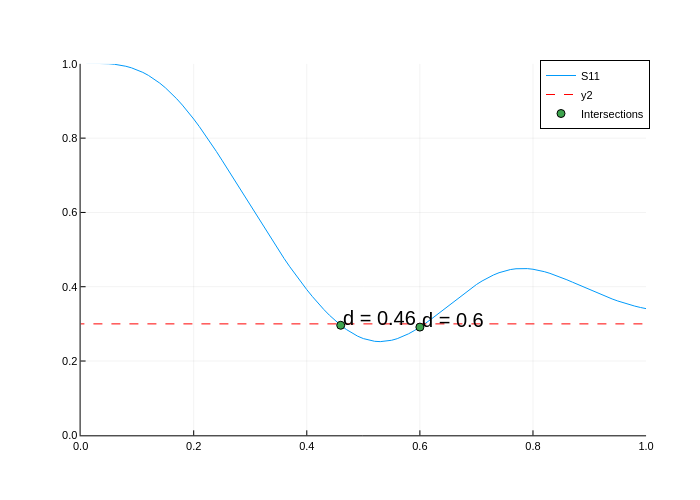

In [84]:
d = 0.01:0.01:1

Z_d = 73.1 + 42.5im # Self-impedance of a half-wave dipole
Z_11 = Z_d * ones(length(d))

Zm = @. parallelMutualImpedance(f, l, d)
Z_12 = complex.(first.(Zm), last.(Zm))

Zm = @. parallelMutualImpedance(f, l, 2d)
Z_13 = complex.(first.(Zm), last.(Zm))

Zin = - 2Z_12.^2 ./ (Z_11 + Z_13) + Z_11

S11 = abs.((Zin - 50 * ones(length(Zin))) ./ (Zin + 50 * ones(length(Zin))))
p = Plots.plot(d, abs.(S11), label="S11", xlims=(0, 1), ylims=(0, 1))
hline!([0.3], linecolor=:red, linestyle=:dash)

intersect_indices = findall(x -> abs(x - 0.3) < 0.01, S11)
scatter!(d[intersect_indices[2:3]], S11[intersect_indices[2:3]], marker=:circle, label="Intersections")
for idx in intersect_indices[2:3]
    annotate!([(d[idx], S11[idx] + 0.02, text("d = $(d[idx])", :left))])
end

display(p)

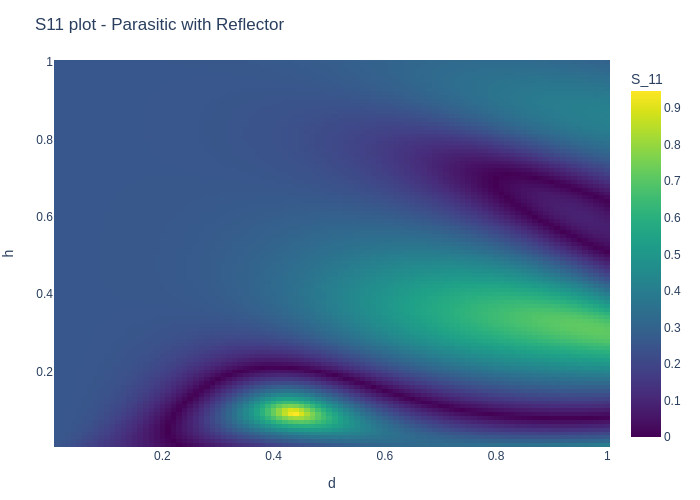

In [92]:
steps = 100
d_max = 1
h_max = 1
step_d = d_max / steps
step_h = h_max / steps

d = step_d:step_d:d_max
h = step_h:step_h:h_max

Zin = Matrix{ComplexF64}(undef, length(d), length(h))
println("Type of Zin: $(typeof(Zin))")
for i in enumerate(d)
    for j in enumerate(h)
        Z_d = 73.1 + 42.5im # Self-impedance of a half-wave dipole
        Z_11 = Z_d

        Zm = parallelMutualImpedance(f, l, i[2])
        Z_12 = complex(first(Zm), last(Zm))

        Zm = parallelMutualImpedance(f, l, 2i[2])
        Z_13 = complex(first(Zm), last(Zm))

        Zm = parallelMutualImpedance(f, l, 2j[2])
        Z_14 = complex(first(Zm), last(Zm))

        Zm = parallelMutualImpedance(f, l, sqrt(i[2]^2 + j[2]^2))
        Z_15 = complex(first(Zm), last(Zm))

        Zm = parallelMutualImpedance(f, l, sqrt(4i[2]^2 + j[2]^2))
        Z_16 = complex(first(Zm), last(Zm))

        Zin[i[1], j[1]] = - 2(Z_12 - Z_15)^2 / (Z_11 + Z_13 - Z_15 - Z_16) + Z_11
    end
end


Zin = abs.(Zin)
S11 = abs.((Zin - 50 * ones(size(Zin))) ./ (Zin + 50 * ones(size(Zin))))
# PlotlyJS.heatmap(d, h, S11, xlabel="d", ylabel="h", title="S11")

trace = PlotlyJS.heatmap(z=S11, x=d, y=h, colorbar_title="S_11", colorscale="Viridis")
layout = Layout(title="S11 plot - Parasitic with Reflector", xaxis_title="d", yaxis_title="h")
p = PlotlyJS.plot(trace, layout)
display(p)